In [1]:
import time
import random
from tqdm import tqdm , trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
 
import torch
from torch import nn, optim, Tensor
 
from torch_sparse import SparseTensor, matmul
 
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [2]:
movie_path = '../data/movies.csv'
rating_path = '../data/ratings.csv'

In [3]:
def load_node_csv(path, index_col):
    """
    Args:
        path (str): 数据集路径
        index_col (str): 数据集文件里的列索引
    Returns:
        dict: 列号和用户ID的索引、列好和电影ID的索引
    """
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}  # enumerate()索引函数,默认索引从0开始
    return mapping


In [4]:
user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')
## movieId ：index
## userId ：index

In [5]:
print(len(user_mapping))

610


In [6]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """
    Args:
        path (str): 数据集路径
        src_index_col (str): 用户列名
        src_mapping (dict): 行号和用户ID的映射
        dst_index_col (str): 电影列名
        dst_mapping (dict): 行号和电影ID的映射
        link_index_col (str): 交互的列名
        rating_threshold (int, optional): 决定选取多少评分交互的阈值，设置为4分
    Returns:
        torch.Tensor: 2*N的用户电影交互节点图
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold  # 将数组转化为tensor张量
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
 
    return torch.tensor(edge_index)

In [7]:
edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [8]:
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]  # 所有索引
 
train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)  # 将数据集划分成80:10的训练集:测试集
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)  # 将测试集划分成10:10的验证集:测试集,最后的比例就是80:10:10
 

In [9]:
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [10]:

Num_train_nodes = num_users+num_movies
print(Num_train_nodes)
Num_val_nodes = num_users+num_movies
print(Num_val_nodes)
print(num_users)
print(num_movies)

10352
10352
610
9742


In [11]:

train_sparse_edge_index = SparseTensor.from_edge_index(
    train_edge_index,
    sparse_sizes=(Num_train_nodes, Num_train_nodes)
)
print(train_sparse_edge_index)
val_sparse_edge_index = SparseTensor.from_edge_index(val_edge_index,
    sparse_sizes=(Num_val_nodes, Num_val_nodes)
 )
print(val_sparse_edge_index)

SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   0,    2,   43,  ..., 9461, 9462, 9463]),
             size=(10352, 10352), nnz=38864, density=0.04%)
SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   5,  184, 1401,  ..., 8570, 8696, 8811]),
             size=(10352, 10352), nnz=4858, density=0.00%)


In [12]:
def sample_mini_batch(batch_size, edge_index):
    """
    Args:
        batch_size (int): 批大小
        edge_index (torch.Tensor): 2*N的边列表
    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
   
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [13]:
def sample_neg(batch_size, edge_index):
    print("sample_neg")
    edge_index = edge_index.to(device)
    num_nodes = edge_index.size(1)
    user_indices, pos_item_indices = edge_index

    neg_item_indices = torch.empty(0, dtype=torch.int64, device=device)  # 指定数据类型和设备
    for i in range(num_nodes):
        random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        while random_index.item() == edge_index[1, i].item():
            random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        random_element = edge_index[1, random_index]
        neg_item_indices = torch.cat((neg_item_indices, random_element), dim=0)

    edge_index_new = torch.stack((user_indices, pos_item_indices, neg_item_indices), dim=0)
    indices = random.choices([i for i in range(edge_index_new[0].shape[0])], k=batch_size)
    batch = edge_index_new[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices


In [14]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=32, K=2, add_self_loops=False, **kwargs):
        """
        Args:
            num_users (int): 用户数量
            num_items (int): 电影数量
            embedding_dim (int, optional): 嵌入维度，设置为64，后续可以调整观察效果
            K (int, optional): 传递层数，设置为3，后续可以调整观察效果
            add_self_loops (bool, optional): 传递时加不加自身节点，设置为不加
        """
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops
 
        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim)  # e_u^0   size: nums_users * embedding_dim
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim)  # e_i^0   size: nums_items * embedding_dim
 
        nn.init.normal_(self.users_emb.weight, std=0.1)  # 从给定均值和标准差的正态分布N(mean, std)中生成值，填充输入的张量或变量
        nn.init.normal_(self.items_emb.weight, std=0.1)
 
    def forward(self, edge_index: SparseTensor):
        """
        Args:
            edge_index (SparseTensor): 邻接矩阵
        Returns:
            tuple (Tensor): e_u%^k, e_u^0, e_i^k, e_i^0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)
 
        emb_0 = torch.cat([self.users_emb.weight, 
                           self.items_emb.weight]) # E^0  size: (nums_items+nums_users) * embedding_dim
        embs = [emb_0]
        emb_k = emb_0
        
 
        # 多尺度扩散
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)
 
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)  # E^K
 
        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items])  # splits into e_u^K and e_i^K
        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
 
    def message(self, x_j: Tensor) -> Tensor:
        return x_j
 
    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

In [15]:
model = LightGCN(num_users, num_movies)

In [16]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """
    Args:
        users_emb_final (torch.Tensor): e_u^k
        users_emb_0 (torch.Tensor): e_u^0
        pos_items_emb_final (torch.Tensor): positive e_i^k
        pos_items_emb_0 (torch.Tensor): positive e_i^0
        neg_items_emb_final (torch.Tensor): negative e_i^k
        neg_items_emb_0 (torch.Tensor): negative e_i^0
        lambda_val (float): λ的值
    Returns:
        torch.Tensor: loss值
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2))  # L2 loss L2范数是指向量各元素的平方和然后求平方根
 
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # 正采样预测分数
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # 负采样预测分数
 
    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
 
    return loss


In [17]:
def get_user_positive_items(edge_index):
    """为每个用户生成正采样字典
    Args:
        edge_index (torch.Tensor): 2*N的边列表
    Returns:
        dict: 每个用户的正采样字典
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [18]:
def RecallPrecision_ATk(groundTruth, r, k):
    """
    Args:
        groundTruth (list): 每个用户对应电影列表的高评分项
        r (list): 是否向每个用户推荐了前k个电影的列表
        k (intg): 确定要计算精度和召回率的前k个电影
    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [19]:
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k
    Args:
        groundTruth (list): 同上一个函数
        r (list): 同上一个函数
        k (int): 同上一个函数
    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)
 
    test_matrix = torch.zeros((len(r), k))
 
    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()


In [20]:
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """
    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2*N列表
        exclude_edge_indices ([type]): 2*N列表
        k (int): 前多少个电影
    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight
 
    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)
 
    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
 
        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)
 
    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)
 
    # get all unique users in evaluated split
    users = edge_index[0].unique()
 
    test_user_pos_items = get_user_positive_items(edge_index)
 
    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]
 
    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))
 
    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)
 
    return recall, precision, ndcg 

In [21]:
def get_neg( edge_index):
    print("get_neg")
    edge_index = edge_index.to(device)
    num_nodes = edge_index.size(1)
    user_indices, pos_item_indices = edge_index

    neg_item_indices = torch.empty(0, dtype=torch.int64, device=device)  # 指定数据类型和设备
    for i in range(num_nodes):
        random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        while random_index.item() == edge_index[1, i].item():
            random_index = torch.randint(0, edge_index.size(1), (1,), device=device)
        random_element = edge_index[1, random_index]
        neg_item_indices = torch.cat((neg_item_indices, random_element), dim=0)

    edge_index_new = torch.stack((user_indices, pos_item_indices, neg_item_indices), dim=0)
    indices = random.choices([i for i in range(edge_index_new[0].shape[0])], k=num_nodes)
    batch = edge_index_new[:, indices]
    return batch

In [22]:
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]
 
    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()
 
    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)
 
    return loss, recall, precision, ndcg

In [23]:
ITERATIONS = 100000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [24]:
model = model.to(device)
model.train()
 
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)
 
val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

In [25]:
print(train_sparse_edge_index)

SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609], device='cuda:0'),
             col=tensor([   0,    2,   43,  ..., 9461, 9462, 9463], device='cuda:0'),
             size=(10352, 10352), nnz=38864, density=0.04%)


In [34]:

train_losses = []
val_losses = []
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
time_start = time.time()
time_end = time.time()
i= 0
for iter in trange(ITERATIONS):
    i=i+1
    print(f"\r{i}", end="")
    time_start = time.time()
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)
    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device),neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()
 
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()
    time_end = time.time()
    #print(f"Time taken for {time_end - time_start}  iter: ",iter)


 33%|███▎      | 32803/100000 [1:05:23<20:22:54,  1.09s/it]

[Iteration 32800/100000] train_loss: -94.84355, val_loss: -85.38945, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 33%|███▎      | 33003/100000 [1:05:45<20:10:53,  1.08s/it]

[Iteration 33000/100000] train_loss: -98.87516, val_loss: -85.74242, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 33%|███▎      | 33203/100000 [1:06:08<20:20:59,  1.10s/it]

[Iteration 33200/100000] train_loss: -102.3941, val_loss: -85.58361, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 33%|███▎      | 33403/100000 [1:06:31<20:08:50,  1.09s/it]

[Iteration 33400/100000] train_loss: -100.00067, val_loss: -85.17481, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 34%|███▎      | 33603/100000 [1:06:54<20:34:09,  1.12s/it]

[Iteration 33600/100000] train_loss: -98.49738, val_loss: -86.10824, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 34%|███▍      | 33803/100000 [1:07:18<20:22:48,  1.11s/it]

[Iteration 33800/100000] train_loss: -100.40553, val_loss: -85.14677, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 34%|███▍      | 34003/100000 [1:07:41<19:53:08,  1.08s/it]

[Iteration 34000/100000] train_loss: -99.46172, val_loss: -85.36887, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 34%|███▍      | 34203/100000 [1:08:03<20:04:54,  1.10s/it]

[Iteration 34200/100000] train_loss: -102.25406, val_loss: -85.54018, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 34%|███▍      | 34403/100000 [1:08:29<22:01:44,  1.21s/it]

[Iteration 34400/100000] train_loss: -103.61739, val_loss: -86.27226, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 35%|███▍      | 34603/100000 [1:08:54<20:33:58,  1.13s/it]

[Iteration 34600/100000] train_loss: -97.91891, val_loss: -86.11169, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 35%|███▍      | 34803/100000 [1:09:17<20:22:56,  1.13s/it]

[Iteration 34800/100000] train_loss: -99.72494, val_loss: -85.64635, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 35%|███▌      | 35003/100000 [1:09:41<20:30:13,  1.14s/it]

[Iteration 35000/100000] train_loss: -98.33095, val_loss: -86.12772, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 35%|███▌      | 35203/100000 [1:10:05<21:58:45,  1.22s/it]

[Iteration 35200/100000] train_loss: -99.36646, val_loss: -84.66911, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 35%|███▌      | 35404/100000 [1:10:31<20:51:08,  1.16s/it]

[Iteration 35400/100000] train_loss: -96.02809, val_loss: -84.91373, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 36%|███▌      | 35603/100000 [1:11:00<26:15:37,  1.47s/it]

[Iteration 35600/100000] train_loss: -98.12745, val_loss: -85.56635, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 36%|███▌      | 35803/100000 [1:11:23<19:57:38,  1.12s/it]

[Iteration 35800/100000] train_loss: -100.86854, val_loss: -85.22603, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 36%|███▌      | 36003/100000 [1:11:47<21:33:28,  1.21s/it]

[Iteration 36000/100000] train_loss: -99.30792, val_loss: -85.33643, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 36%|███▌      | 36203/100000 [1:12:13<25:00:53,  1.41s/it]

[Iteration 36200/100000] train_loss: -99.5908, val_loss: -85.77053, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 36%|███▋      | 36403/100000 [1:12:38<19:07:38,  1.08s/it]

[Iteration 36400/100000] train_loss: -98.35342, val_loss: -85.89388, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 37%|███▋      | 36603/100000 [1:13:01<21:04:44,  1.20s/it]

[Iteration 36600/100000] train_loss: -98.55279, val_loss: -85.97527, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 37%|███▋      | 36803/100000 [1:13:25<20:40:23,  1.18s/it]

[Iteration 36800/100000] train_loss: -100.48499, val_loss: -85.42103, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 37%|███▋      | 37003/100000 [1:13:49<20:15:11,  1.16s/it]

[Iteration 37000/100000] train_loss: -97.94402, val_loss: -86.1939, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 37%|███▋      | 37203/100000 [1:14:12<19:19:33,  1.11s/it]

[Iteration 37200/100000] train_loss: -98.75332, val_loss: -85.44694, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 37%|███▋      | 37403/100000 [1:14:36<19:23:33,  1.12s/it]

[Iteration 37400/100000] train_loss: -93.34132, val_loss: -84.99197, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 38%|███▊      | 37603/100000 [1:14:59<19:27:55,  1.12s/it]

[Iteration 37600/100000] train_loss: -94.87885, val_loss: -85.98043, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 38%|███▊      | 37803/100000 [1:15:23<19:30:08,  1.13s/it]

[Iteration 37800/100000] train_loss: -100.07269, val_loss: -86.86961, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 38%|███▊      | 38003/100000 [1:15:46<18:36:38,  1.08s/it]

[Iteration 38000/100000] train_loss: -99.1041, val_loss: -85.06733, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 38%|███▊      | 38203/100000 [1:16:10<19:37:33,  1.14s/it]

[Iteration 38200/100000] train_loss: -97.24821, val_loss: -85.54716, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 38%|███▊      | 38403/100000 [1:16:33<18:10:58,  1.06s/it]

[Iteration 38400/100000] train_loss: -100.40199, val_loss: -86.05659, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 39%|███▊      | 38603/100000 [1:16:55<18:50:51,  1.11s/it]

[Iteration 38600/100000] train_loss: -96.33147, val_loss: -86.10436, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 39%|███▉      | 38803/100000 [1:17:19<19:22:41,  1.14s/it]

[Iteration 38800/100000] train_loss: -100.45494, val_loss: -85.81287, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 39%|███▉      | 39003/100000 [1:17:43<19:08:53,  1.13s/it]

[Iteration 39000/100000] train_loss: -97.33179, val_loss: -85.72388, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 39%|███▉      | 39203/100000 [1:18:04<17:42:29,  1.05s/it]

[Iteration 39200/100000] train_loss: -101.45878, val_loss: -86.14044, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 39%|███▉      | 39403/100000 [1:18:28<18:13:15,  1.08s/it]

[Iteration 39400/100000] train_loss: -95.28227, val_loss: -86.21354, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 40%|███▉      | 39603/100000 [1:18:49<17:18:12,  1.03s/it]

[Iteration 39600/100000] train_loss: -99.28495, val_loss: -85.04958, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 40%|███▉      | 39803/100000 [1:19:12<18:51:09,  1.13s/it]

[Iteration 39800/100000] train_loss: -99.1235, val_loss: -85.30232, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 40%|████      | 40003/100000 [1:19:35<18:23:45,  1.10s/it]

[Iteration 40000/100000] train_loss: -97.0814, val_loss: -85.29531, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 40%|████      | 40203/100000 [1:19:57<17:16:30,  1.04s/it]

[Iteration 40200/100000] train_loss: -100.14456, val_loss: -84.81886, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 40%|████      | 40403/100000 [1:20:20<19:03:02,  1.15s/it]

[Iteration 40400/100000] train_loss: -98.20558, val_loss: -85.8347, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 41%|████      | 40603/100000 [1:20:42<18:03:23,  1.09s/it]

[Iteration 40600/100000] train_loss: -102.07591, val_loss: -85.99305, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 41%|████      | 40803/100000 [1:21:05<17:14:40,  1.05s/it]

[Iteration 40800/100000] train_loss: -97.10526, val_loss: -85.5632, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 41%|████      | 41003/100000 [1:21:28<18:42:28,  1.14s/it]

[Iteration 41000/100000] train_loss: -100.64285, val_loss: -86.46677, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 41%|████      | 41203/100000 [1:21:51<18:17:43,  1.12s/it]

[Iteration 41200/100000] train_loss: -98.54516, val_loss: -85.93966, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 41%|████▏     | 41403/100000 [1:22:14<18:17:16,  1.12s/it]

[Iteration 41400/100000] train_loss: -96.46104, val_loss: -84.96462, val_recall@20: 0.15453, val_precision@20: 0.04647, val_ndcg@20: 0.1069


 41%|████▏     | 41471/100000 [1:22:19<1:56:11,  8.40it/s] 


KeyboardInterrupt: 

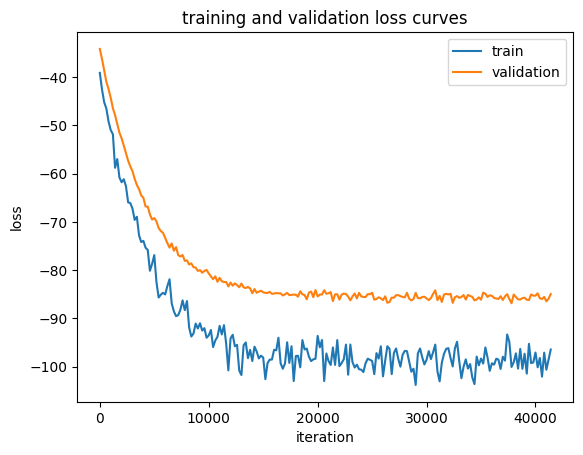

In [35]:

iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()